# Next generation reservoir computing

Azimov Sherkhon \\

Pusan National University \\

sherxonazimov94@pusan.ac.kr \\

The part of this code is imported from NATURE COMMUNICATIONS | https://doi.org/10.1038/s41467-021-25801-2

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

In [2]:
# Seed setup
seed = 2025
np.random.seed(seed)

In [3]:
# Time parameters
s = 4
dt = 0.025*s
warmup, traintime, testtime, plottime = 5.0, 40.0, 5.0, 5.0
maxtime = warmup + traintime + testtime

# Discrete time steps
warmup_pts = round(warmup / dt)
traintime_pts = round(traintime / dt+1)
warmtrain_pts = warmup_pts + traintime_pts
testtime_pts = round(testtime / dt)
maxtime_pts = round(maxtime / dt)
plottime_pts = round(plottime / dt)

In [4]:
# Lorenz system definition
sigma, beta, rho = 10, 8/3, 28

def lorenz(t, y):
    return [
        sigma * (y[1] - y[0]),
        y[0] * (rho - y[2]) - y[1],
        y[0] * y[1] - beta * y[2]
    ]
# Seed setup
seed = 2025
np.random.seed(seed)
# Integrate Lorenz system
t_eval = np.linspace(0, maxtime, maxtime_pts*s + 1)
sol = solve_ivp(lorenz, (0, maxtime), [-8.0, 7.0, 27.0], t_eval=t_eval, method="RK23")
lorenz_data = sol.y.T
t_eval = t_eval[::s]
lorenz_data = lorenz_data[::s,:]
X_clean = lorenz_data.T
# Add Gaussian noise
def add_noise(data, scale):
    std = np.std(data, axis=0)
    noise = np.random.normal(0.0, scale * std, data.shape)
    return data + noise

X_noisy = add_noise(lorenz_data, 0.10)
lorenz_soln = X_noisy.T

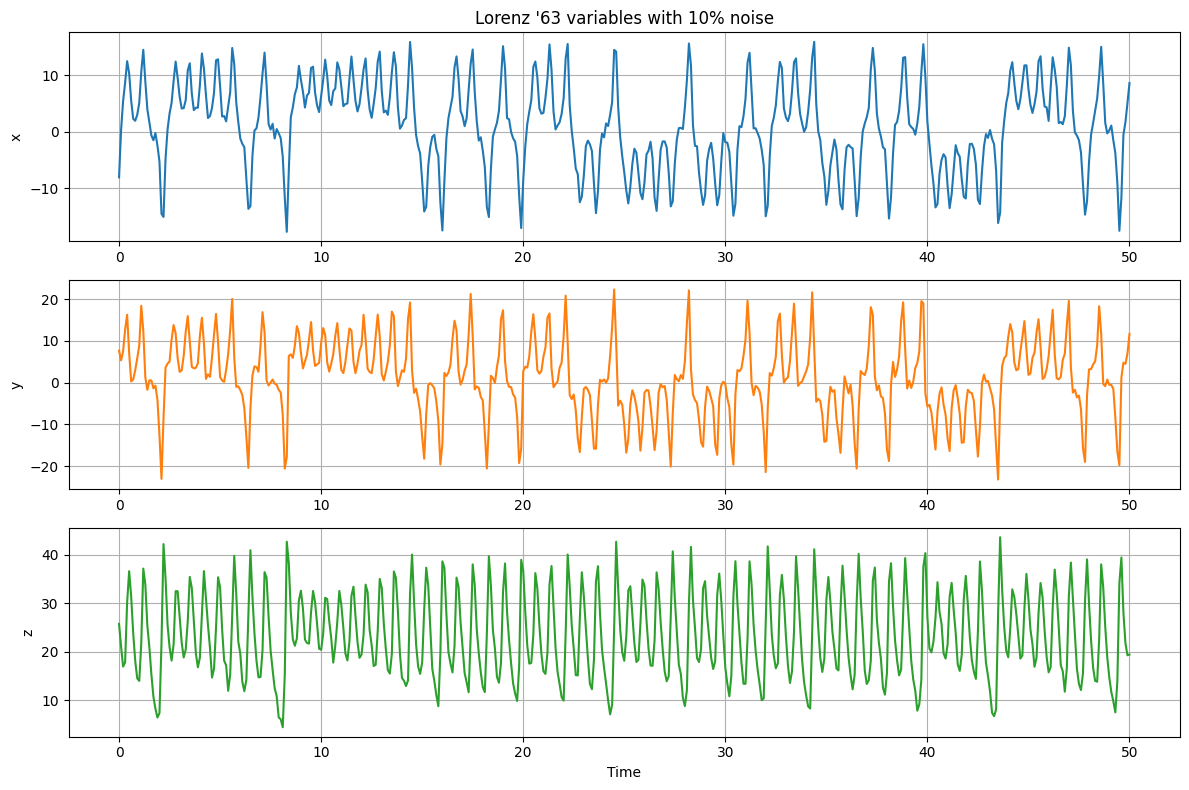

In [5]:
# Plot noisy Lorenz variables
variables = ['x', 'y', 'z']
plt.figure(figsize=(12, 8))
for i in range(3):
    plt.subplot(3, 1, i + 1)
    plt.plot(t_eval, X_noisy[:, i], label=variables[i], color=f'C{i}')
    plt.ylabel(variables[i])
    plt.grid(True)
    if i == 0:
        plt.title("Lorenz '63 variables with 10% noise")
plt.xlabel('Time')
plt.tight_layout()
plt.show()

In [6]:
# NVAR Setup
d, k = 3, 2          # from the grid search code (Best k = 5, ridge = 53.470 → Validation RMSE = 7.653195)
ridge_param = 53.470     
dlin = k * d
dnonlin = int(dlin * (dlin + 1) / 2)
dtot = 1 + dlin + dnonlin

In [7]:
# Delay embedding
x = np.zeros((dlin, maxtime_pts))
for delay in range(k):
    for j in range(delay,maxtime_pts):
        x[d*delay:d*(delay+1),j]=lorenz_soln[:,j-delay]

# Prepare training data
out_train = np.ones((dtot, traintime_pts))
out_train[1:dlin + 1, :] = x[:, warmup_pts - 1:warmtrain_pts - 1]
cnt = 0
for i in range(dlin):
    for j in range(i, dlin):
        out_train[dlin + 1 + cnt] = x[i, warmup_pts - 1:warmtrain_pts - 1] * x[j, warmup_pts - 1:warmtrain_pts - 1]
        cnt += 1

delta_x = x[:d, warmup_pts:warmtrain_pts] - x[:d, warmup_pts - 1:warmtrain_pts - 1]
W_out = delta_x @ out_train.T @ np.linalg.pinv(out_train @ out_train.T + ridge_param * np.identity(dtot))

In [8]:
# Training prediction
x_predict = x[:d, warmup_pts - 1:warmtrain_pts - 1] + W_out @ out_train
train_rmse = np.sqrt(np.mean((x[:d, warmup_pts:warmtrain_pts] - x_predict) ** 2))
print(f"Training RMSE: {train_rmse:.6f}")

Training RMSE: 1.765346


In [9]:
# create a place to store feature vectors for prediction
out_test = np.zeros(dtot)              # full feature vector
x_test = np.zeros((dlin,testtime_pts)) # linear part

# copy over initial linear feature vector
x_test[:,0] = x[:,warmtrain_pts-1]

# do prediction
for j in range(testtime_pts-1):
    # copy linear part into whole feature vector
    out_test[1:dlin+1]=x_test[:,j] # shift by one for constant
    # fill in the non-linear part
    cnt=0
    for row in range(dlin):
        for column in range(row,dlin):
            # shift by one for constant
            out_test[dlin+1+cnt]=x_test[row,j]*x_test[column,j]
            cnt += 1
    # fill in the delay taps of the next state
    x_test[d:dlin,j+1]=x_test[0:(dlin-d),j]
    # do a prediction
    x_test[0:d,j+1] = x_test[0:d,j]+W_out @ out_test[:]
X_true_noise = x[:3,warmtrain_pts-1:warmtrain_pts+plottime_pts-1]
# Forecast evaluation
#X_true = X_clean[:3,warmtrain_pts+1:: ]   # clean data
X_true = X_clean[:3,warmtrain_pts-1:warmtrain_pts-1+testtime_pts ]   # clean data
X_prediction = x_test[:3,:]

In [10]:
# Forecast evaluation
print(X_true.shape)
print(X_prediction.shape)

(3, 50)
(3, 50)


In [11]:
# Save prediction for plotting with adaptive NVAR
np.save("testngrc_10noise_obs_4.npy", X_prediction)

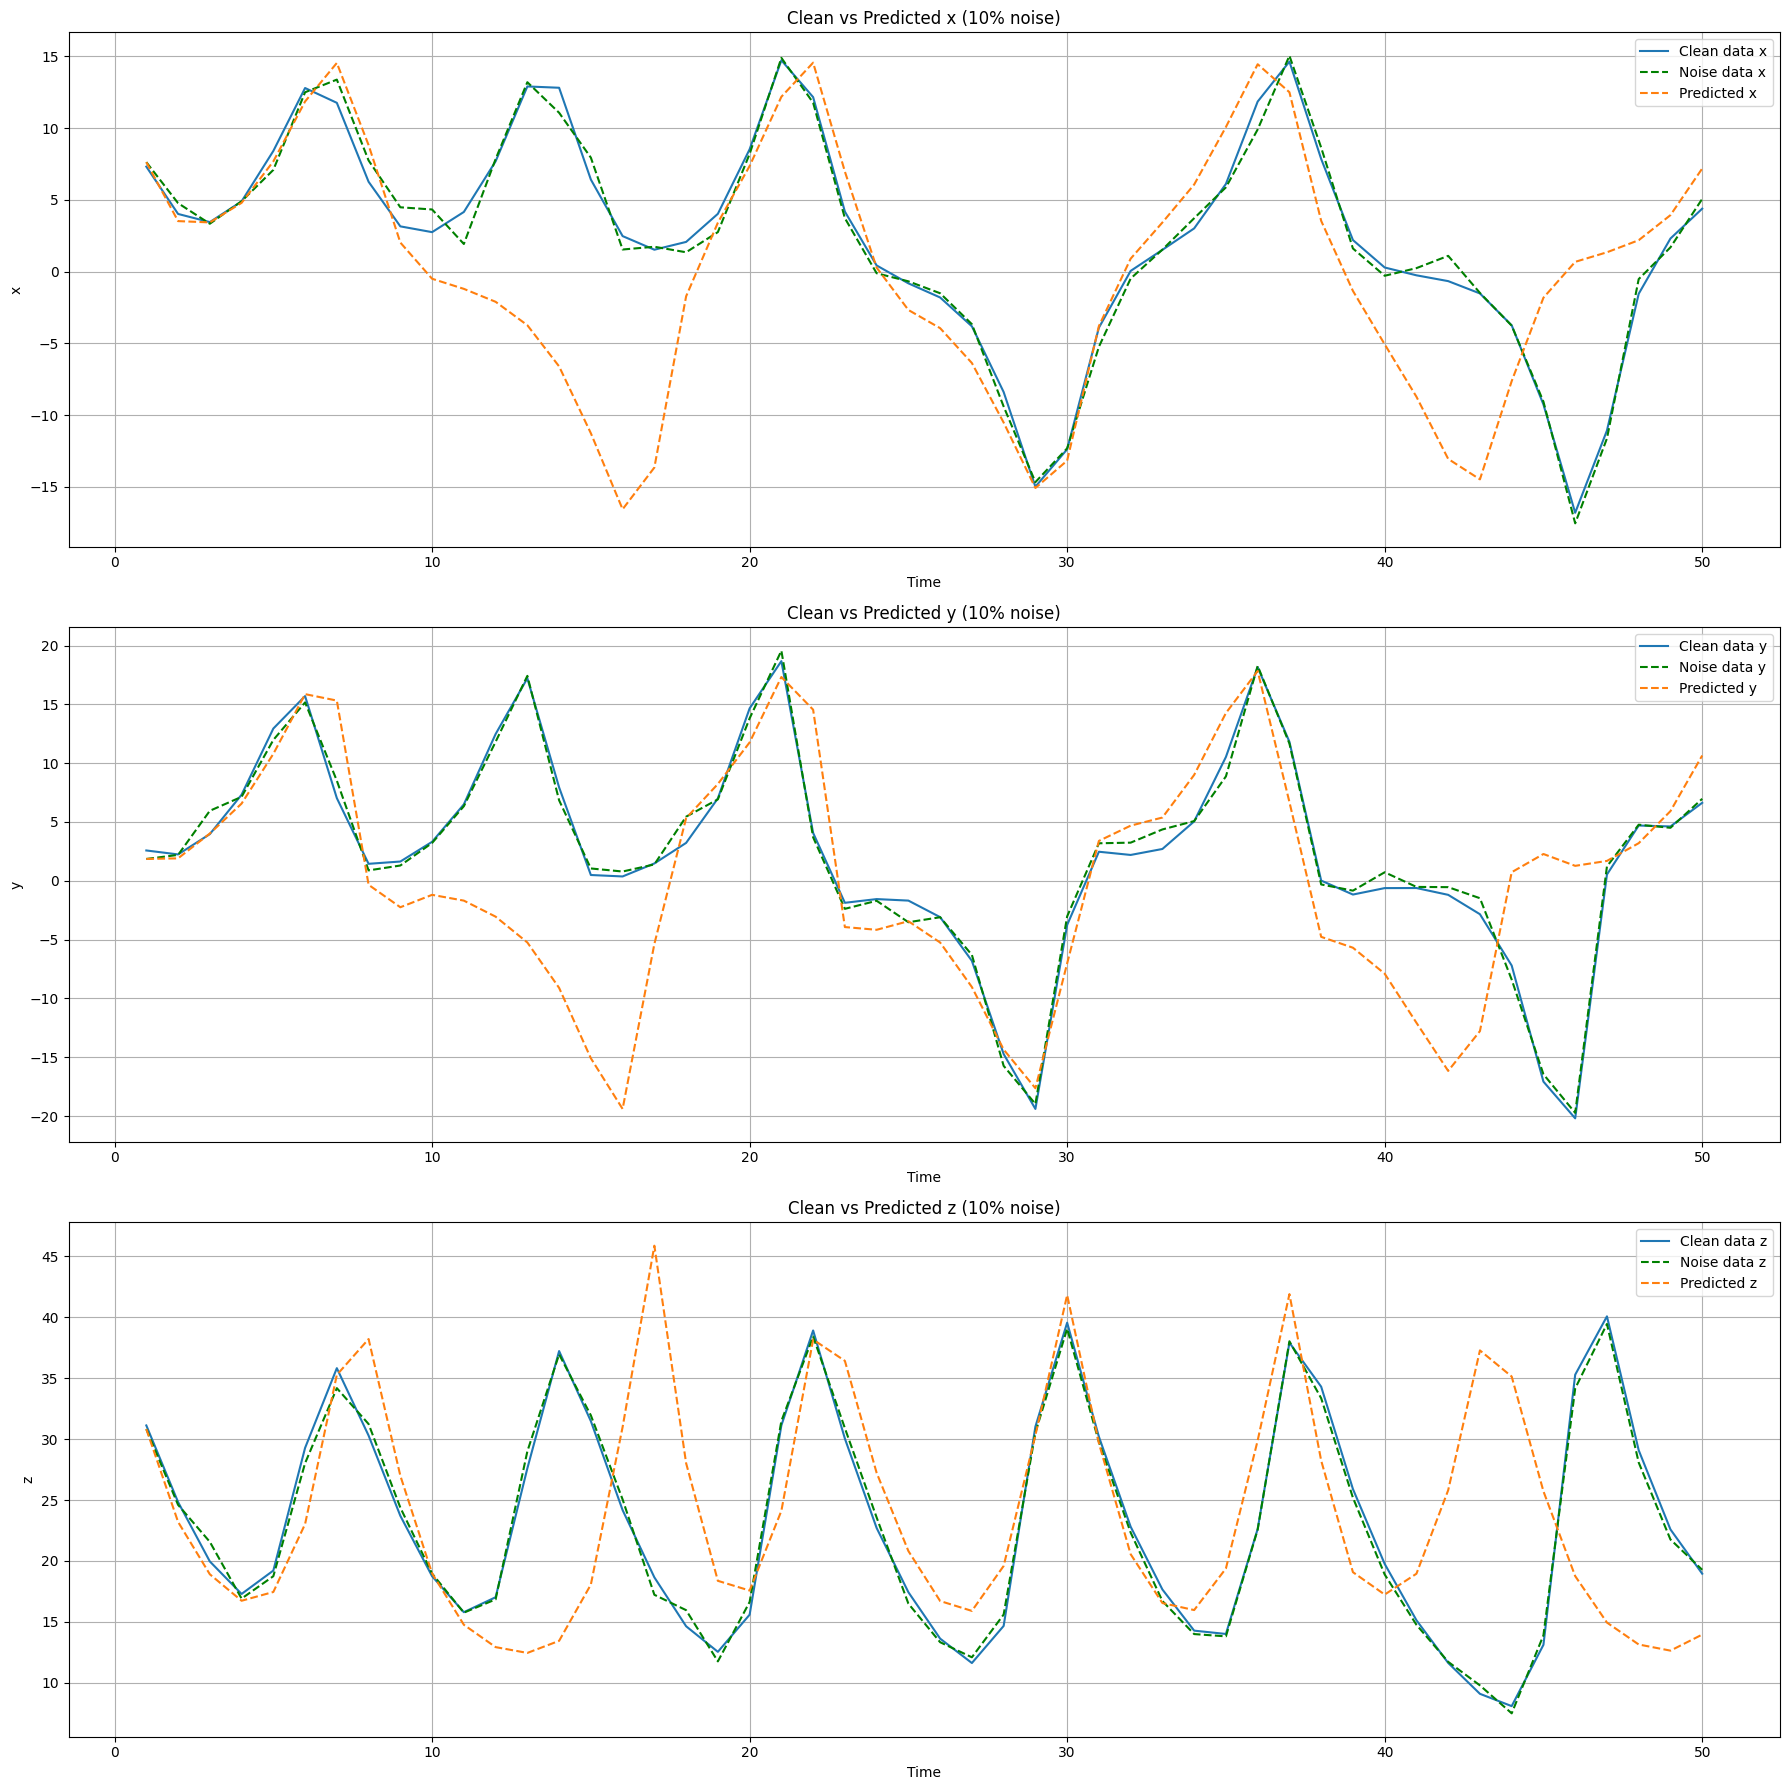

In [13]:

t_plot = np.arange(1, 51)
# Plot
plt.figure(figsize=(18, 18))
for i in range(3):
    plt.subplot(3, 1, i + 1)
    plt.plot(t_plot, X_true[i], label=f'Clean data {variables[i]}')
    plt.plot(t_plot, X_true_noise[i], label=f'Noise data {variables[i]}', linestyle='--', color="green")
    plt.plot(t_plot, X_prediction[i], label=f'Predicted {variables[i]}', linestyle='--')    
    plt.xlabel('Time')
    plt.ylabel(f'{variables[i]}')
    plt.title(f'Clean vs Predicted {variables[i]} (10% noise)')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.savefig('predict-lorenz-10%_noise_obs_4.png', dpi=300, bbox_inches='tight')
plt.show()




In [14]:
horizons = [5, 10, 15, 25]
print("\nRMSE per variable for different forecast horizons:")
for h in horizons:
    rmse = np.sqrt(np.mean((X_true[:, :h] - X_prediction[:, :h]) ** 2, axis=1))
    print(f"\n--- Forecast Horizon: {h} steps ---")
    for i, r in enumerate(rmse):
        print(f"Variable {variables[i]} RMSE: {r:.6f}")


RMSE per variable for different forecast horizons:

--- Forecast Horizon: 5 steps ---
Variable x RMSE: 0.421692
Variable y RMSE: 1.081107
Variable z RMSE: 1.205530

--- Forecast Horizon: 10 steps ---
Variable x RMSE: 1.669325
Variable y RMSE: 3.365811
Variable z RMSE: 3.468957

--- Forecast Horizon: 15 steps ---
Variable x RMSE: 8.641093
Variable y RMSE: 9.863352
Variable z RMSE: 8.616431

--- Forecast Horizon: 25 steps ---
Variable x RMSE: 8.373901
Variable y RMSE: 9.026461
Variable z RMSE: 9.467466
